# Crash Course

As an example, let’s define our likelihood to be a 3-D correlated multivariate Normal (Gaussian) distribution and our prior to be uniform in each dimension from [-10, 10):

In [ ]:
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Estimating the evidence and posterior is as simple as:

In [ ]:
import dynesty

# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

In [ ]:
sresults.summary()

Combining the results from multiple (independent) runs is easy:

In [ ]:
from dynesty import utils as dyfunc

# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

We can visualize our results using several of the built-in plotting utilities. For instance:

In [ ]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

We can post-process these results using some built-in utilities. For instance:

In [ ]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = results.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = results.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(results)

# Getting Started

### Prior Transforms

In [ ]:
# Uniform Prior
def prior_transform(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""

    x = 2. * u - 1.  # scale and shift to [-1., 1.)
    x *= 10.  # scale to [-10., 10.)

    return x

# Non-uniform Prior

def nu_prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    # Bivariate Normal
    t = scipy.stats.norm.ppf(u[0:2])  # convert to standard normal
    Csqrt = np.array([[2., 1.],
                      [1., 2.]])  # C^1/2 for C=((5, 4), (4, 5))
    x[0:2] = np.dot(Csqrt, t)  # correlate with appropriate covariance
    mu = np.array([5., 2.])  # mean
    x[0:2] += mu  # add mean

    # Beta
    a, b = 2.31, 0.627  # shape parameters
    x[2] = scipy.stats.beta.ppf(u[2], a, b)

    # Gamma
    alpha = 5.  # shape parameter
    x[3] = scipy.stats.gamma.ppf(u[3], alpha)

    # Truncated Normal
    m, s = 5, 2  # mean and standard deviation
    low, high = 2., 10.  # lower and upper bounds
    low_n, high_n = (low - m) / s, (high - m) / s  # standardize
    x[4] = scipy.stats.truncnorm.ppf(u[4], low_n, high_n, loc=m, scale=s)

    return x


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

u = np.linspace(0,1,100)
x = prior_transform(u)
nu_x = nu_prior_transform(u)

### Conditional Priors

In [ ]:
def conditional_prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    # Mean hyper-prior
    mu, sigma = 5., 1.  # mean, standard deviation
    x[0] = scipy.stats.norm.ppf(u[0], loc=mu, scale=sigma)

    # Standard deviation hyper-prior
    x[1] = 10. ** (u[1] * 2. - 1.)  # log10(std) ~ Uniform[-1, 1]

    # Prior
    x[2] = scipy.stats.norm.ppf(u[2], loc=x[0], scale=x[1])

    return x


In [ ]:
cond_x = conditional_prior_transform(u)

## Nested Sampling with Dynesty

In [ ]:
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal log-likelihood.
C = np.identity(ndim)
C[C==0] = 0.95
Cinv = np.linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))

def loglike(x):
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior via the prior transform.
def ptform(u):
    return 20. * u - 10.

In [ ]:
from dynesty import NestedSampler

# initialize our nested sampler
sampler = NestedSampler(loglike, ptform, ndim)

Live points: increasing the number of LP's improves the effective resolution but simultaneously increases the runtime. As a rule of thumb you should allocate 50 LP's per possible mode. The default is 250 and can be set using nlive = ___ as an argument.


Bounding options: (default is multi, set using bound=___ argument)

    - No bound ('none') samples the entire cube (inefficient but useful to look for biases)
    - single ellipsoid ('single') (for simple distributions)
    - multiple (possibly overlapping) ellipsoids ('multi') (captures complexity, simple and quick)
    - overlapping balls centered on each LP ('balls') (for more complex distributions, but less efficient)
    - overlapping cubes centered on each LP ('cubes') (for more complex distributions, but less efficient)

Sampling Options: (automatically picks a sampling method based on dim of the problem via the sample='auto' argument

    - uniform ('unif')
    - random walk ('rwalk')
    - multivariate slice sampling ('slice')
    - random slice sampling ('rslice')
    - Hamiltonian slice sampling ('hslice')
    
    

In [ ]:
sampler = NestedSampler(loglike, ptform, ndim, nlive=1000)
sampler.run_nested()

# Results

In [ ]:
results = sampler.results

In [ ]:
results.summary()

In [ ]:
from dynesty import plotting as dyplot

A summary (run) plot can be generated using runplot(results). It shows:

    1. The effective iteration illustrating how quickly/slowly our samples are compressing the prior volume.
    2. Likelihood, to see how smoothing we sample 'up' the likelihood distribution to the maximum likelihood.
    3. Importance weight showcasing where the bulk of the posterior mass is located.
    4. The evidence to see where most of the contribution to the evidence (and its error) comes from.
    
We can also calculate the actual analytic ln(Z) evidence solution, and add it to the plot as lnz_truth (red line)

In [ ]:
lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution

rfig, raxes = dyplot.runplot(results, lnz_truth=lnz_truth)

We can also visualise the results by generating a trace plot, showing the evolution of particles (and their marginal posterior distributions) in 1D projections. Colour weighting is done by importance weight.

In [ ]:
fig, axes = dyplot.traceplot(results, truths=np.zeros(ndim),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(1))
# connect = True shows the paths of 'particle positions' (moving between live points in iterations)
# connect_highlight=range(x) where x is the number of paths we wish to show

plt.tight_layout()

Corner plots show a combination of 1D and 2D marginalized posteriors. kde=True colours by the estimated posterior mass, and kde=False colours by raw importance weights.

In [ ]:
# 2D only

# raw importance weights
fig, ax = dyplot.cornerpoints(results, cmap='viridis', truths=np.zeros(ndim),
                             kde=False)

# estimated posterior mass
fig, ax = dyplot.cornerpoints(results, cmap='viridis', truths=np.zeros(ndim),
                             kde=True)

The cornerplot function shows the marginal 1D and 2D posterior density estimates together

In [ ]:

fig, ax = dyplot.cornerplot(results, color='blue', truths=np.zeros(ndim),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3)


Bounding distribution plots show how we're sampling in nested 'shells' by looking at the evolution of our bounding distributions in a given 2D projection over the course of a run using the boundplot() function.

In [ ]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*results.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.boundplot(results, dims=(0, 1), it=it,
                            prior_transform=prior_transform,
                            max_n_ticks=3, show_live=True,
                            span=[(-10, 10), (-10, 10)],
                            fig=(fig, a))
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()

In [ ]:
fig, axes = dyplot.cornerbound(results, it=5000,
                              prior_transform=prior_transform,
                              show_live=True,
                              span=[(-10, 10), (-10, 10)])

# Examples

### Fitting Polynomials


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import NestedSampler
from scipy.stats import norm
from dynesty import plotting as dyplot
from dynesty.utils import quantile
import pandas as pd

In [2]:
def get_params(dim, lower, upper):
    params = np.random.uniform(lower, upper, dim)
    return params

def data_generation(params, x):
    return sum(p * x**i for i, p in enumerate(reversed(params)))

def models(theta, dim=2):
    return sum(t * x**i for i, t in enumerate(reversed(theta)))


# Choose priors to be uniform priors between a reasonable range for each parameter
# u will be a uniform distribution from 0-1. Rescale as required
def prior_transform(u, dim):
    return 10 * (2 * np.array(u[:dim]) - 1)

def log_likelihood(theta, dim, sigma):
    y_model = models(theta, dim) 
    return -0.5 * np.sum(((y - y_model) / sigma**2) ** 2) - 0.5* np.log(2*np.pi*sigma**2)


# Functions for saving and storing the parameters
def save_params(result):
    samples = result['samples']
    weights = np.exp(result['logwt'] - np.max(result['logwt']))  # Normalize weights

    num_params = samples.shape[1]
    param_labels = [f'param_{i+1}' for i in range(num_params)]

    quantiles = [0.025, 0.5, 0.975]  # 2σ credible interval
    param_stats = {label: quantile(samples[:, i], quantiles, weights=weights) for i, label in enumerate(param_labels)}

    param_dict = {
        label: {
            'median': q50,
            'lower_uncertainty': q50 - q025,
            'upper_uncertainty': q975 - q50
        } 
        for label, (q025, q50, q975) in param_stats.items()
    }

    # Converting to a df for ease
    params_df = pd.DataFrame.from_dict(param_dict, orient='index')
    return params_df 

def store_parameters(results):
    dataframes = []
    for result in results:
        df = save_params(result)
        dataframes.append(df)
    return dataframes

def extract_evidence(data_dict):
    bayesian_evidence = []
    evidence_error = []
    for key in data_dict:
        evidence = data_dict[key]['logz'][-1]
        bayesian_evidence.append(evidence)
        
        error = data_dict[key]['logzerr'][-1]
        evidence_error.append(error)
        
    return bayesian_evidence, evidence_error

True parameters:  [-0.50183952  1.80285723  0.92797577  0.39463394]


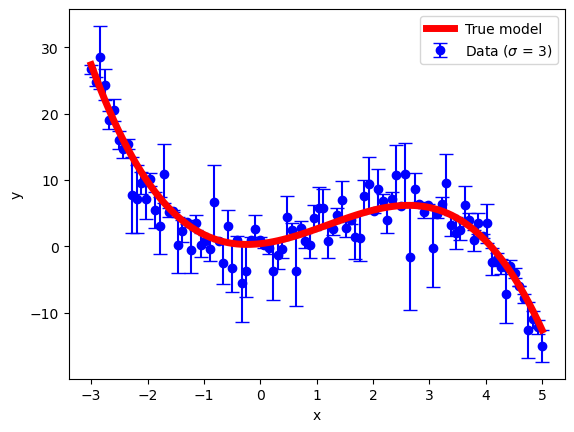

In [10]:
# Define true parameters
np.random.seed(42)

dim = 4 #Set the number of parameters (degree of polynomial = dim - 1 )
lower, upper = -2 , 2 # bounds to draw parameters from 
true_params = get_params(dim, lower, upper)
print('True parameters: ',true_params)

# Generate x values
x = np.linspace(-3, 5, 100) # set data range

# Generate y values (linear relationship with Gaussian noise)
sigma = 3
y_true = data_generation(true_params, x)
yerr = np.random.normal(scale=sigma, size=x.shape)
y = y_true + yerr

plt.errorbar(x, y, yerr=abs(yerr), marker='o', ls='',label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='blue', capsize=5, zorder=0)
plt.plot(x, y_true, label='True model', color='red', lw=5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# plt.savefig('./generated_cubic_data.png', dpi=300)
plt.show()


In [11]:
dim = 3
quad_sampler = NestedSampler(lambda theta: log_likelihood(theta, dim, sigma),
                             lambda u: prior_transform(u, dim), ndim=dim, nlive=1000)
quad_sampler.run_nested()
quad_results = quad_sampler.results

dim = 4 
cub_sampler = NestedSampler(lambda theta: log_likelihood(theta, dim, sigma),
                            lambda u: prior_transform(u, dim), ndim=dim, nlive=1000)
cub_sampler.run_nested()
cub_results = cub_sampler.results

dim = 5
quart_sampler = NestedSampler(lambda theta: log_likelihood(theta, dim, sigma),
                            lambda u: prior_transform(u, dim), ndim=dim, nlive=1000)
quart_sampler.run_nested()
quart_results = quart_sampler.results

9236it [00:12, 737.06it/s, +1000 | bound: 8 | nc: 1 | ncall: 47105 | eff(%): 22.201 | loglstar:   -inf < -25.221 <    inf | logz: -34.358 +/-  0.099 | dlogz:  0.001 >  1.009]
13435it [00:19, 672.79it/s, +1000 | bound: 14 | nc: 1 | ncall: 57624 | eff(%): 25.493 | loglstar:   -inf < -6.282 <    inf | logz: -19.701 +/-  0.124 | dlogz:  0.001 >  1.009]
18363it [00:31, 581.04it/s, +1000 | bound: 24 | nc: 1 | ncall: 71972 | eff(%): 27.283 | loglstar:   -inf < -6.295 <    inf | logz: -24.747 +/-  0.147 | dlogz:  0.001 >  1.009]   


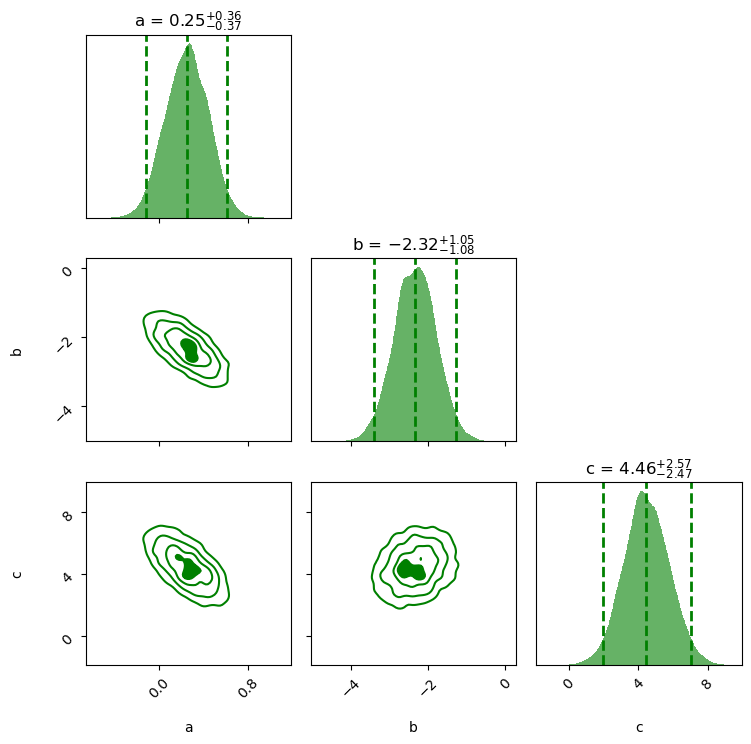

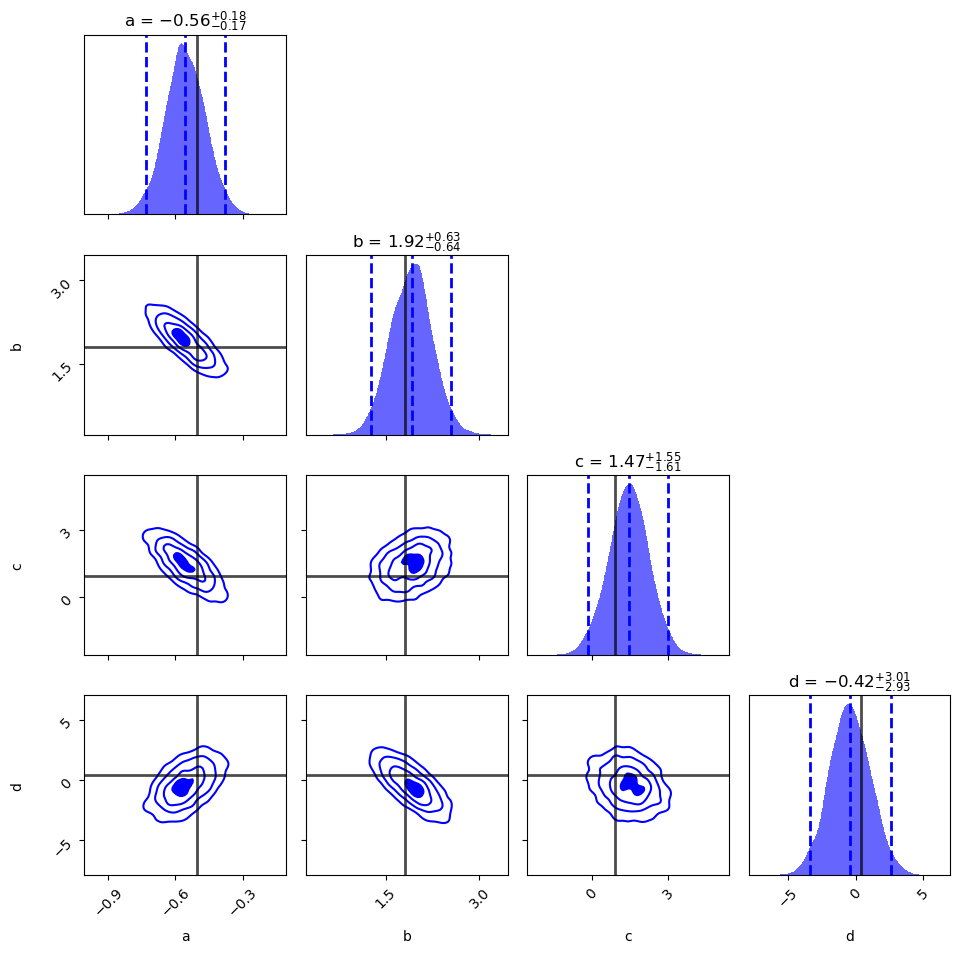

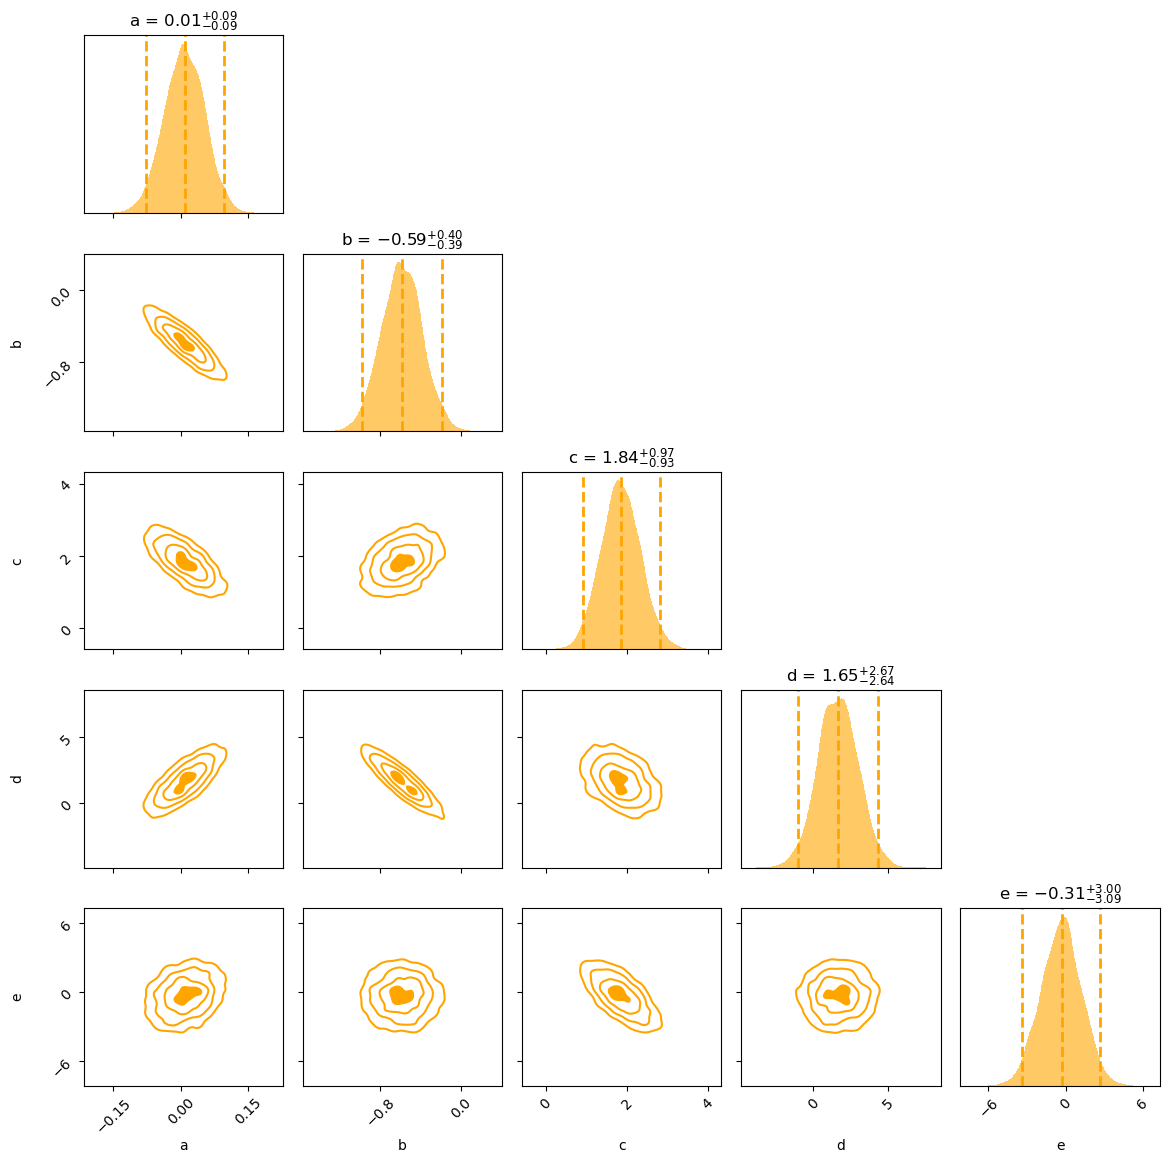

In [16]:
fig, ax = dyplot.cornerplot(quad_results, color='green', truths=None,
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, labels=['a','b','c'])
plt.tight_layout()
# plt.savefig('../Figures/quad_corner_plot.png',dpi=300)

fig, ax = dyplot.cornerplot(cub_results, color='blue', truths=true_params,
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, labels=['a','b','c', 'd'])
plt.tight_layout()
# plt.savefig('../Figures/cubic_corner_plot.png',dpi=300)

fig, ax = dyplot.cornerplot(quart_results, color='orange', truths=None,
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, labels=['a','b','c', 'd', 'e'])
plt.tight_layout()
# plt.savefig('../Figures/quart_corner_plot.png',dpi=300)

In [13]:
quad_Z = quad_results['logz'][-1]
print('Evidence (quad): ', quad_Z)
cub_Z = cub_results['logz'][-1]
print('Evidence (cubic): ', cub_Z)
quart_Z = quart_results['logz'][-1]
print('Evidence (quart): ', quart_Z)
# print('Bayes Factor:  ', quad_Z - cub_Z) # + means first model is better, - means the second performed better

Evidence (quad):  -34.35794545770288
Evidence (cubic):  -19.700667648036223
Evidence (quart):  -24.746965661956317


In [14]:
results = [quad_results, cub_results, quart_results] # Select which models we want parameters for
model_parameters = store_parameters(results)


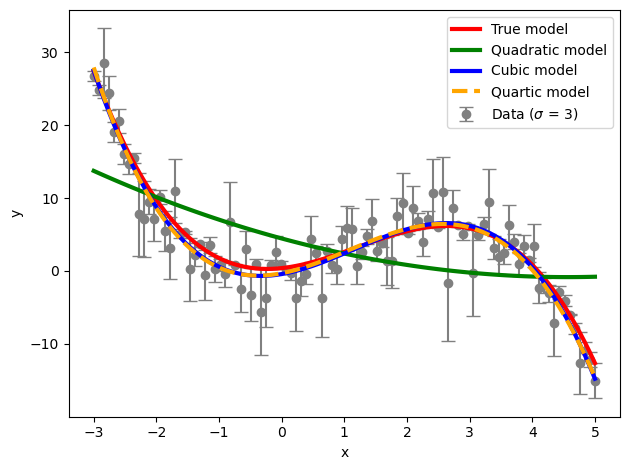

In [17]:
# Compare the predicted fits from each model to the true model 

plt.errorbar(x, y, yerr=abs(yerr), marker='o', ls='',label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='grey', capsize=5, zorder=0)
plt.plot(x, y_true, label='True model', color='red', lw=3)


# Quadratic
quad_y = data_generation(model_parameters[0]['median'],x)
plt.plot(x,quad_y, label='Quadratic model', color='g', lw=3)

#Cubic
cub_y = data_generation(model_parameters[1]['median'], x)
plt.plot(x,cub_y, label='Cubic model', color='b', lw=3)

# Quartic
quart_y = data_generation(model_parameters[2]['median'], x)
plt.plot(x,quart_y, label='Quartic model', color='orange', lw=3, ls='--')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
# plt.savefig('../Figures/polynomial_fits_comparison.png', dpi=300)
plt.show()

In [18]:
# Running over higher order models to compare their evidence
data_dict = {}

max_dim = 8 # Set the maximum number of parameters we want to model
for dim in range(1,max_dim+1):
    sampler =  NestedSampler(lambda theta: log_likelihood(theta, dim, sigma),
                             lambda u: prior_transform(u, dim), ndim=dim, nlive=1000)
    sampler.run_nested()
    results = sampler.results
    
    data_dict[f'dim_{dim}'] = results

bayesian_evidence, evidence_error = extract_evidence(data_dict)

2535it [00:01, 1448.04it/s, +1000 | bound: 0 | nc: 1 | ncall: 13844 | eff(%): 27.523 | loglstar:   -inf < -37.263 <    inf | logz: -39.411 +/-    nan | dlogz:  0.001 >  1.009]
5493it [00:09, 579.09it/s, +1000 | bound: 3 | nc: 1 | ncall: 40322 | eff(%): 16.512 | loglstar:   -inf < -26.122 <    inf | logz: -31.378 +/-  0.066 | dlogz:  0.001 >  1.009]
9105it [00:16, 558.36it/s, +1000 | bound: 8 | nc: 1 | ncall: 46127 | eff(%): 22.392 | loglstar:   -inf < -25.213 <    inf | logz: -34.223 +/-  0.099 | dlogz:  0.001 >  1.009]
13560it [00:21, 633.33it/s, +1000 | bound: 14 | nc: 1 | ncall: 57157 | eff(%): 25.927 | loglstar:   -inf < -6.345 <    inf | logz: -19.886 +/-  0.125 | dlogz:  0.001 >  1.009]
18333it [00:29, 622.99it/s, +1000 | bound: 24 | nc: 1 | ncall: 70811 | eff(%): 27.693 | loglstar:   -inf < -6.309 <    inf | logz: -24.722 +/-  0.147 | dlogz:  0.001 >  1.009]   
24225it [00:51, 468.31it/s, +1000 | bound: 38 | nc: 1 | ncall: 92144 | eff(%): 27.676 | loglstar:   -inf < -6.251 <    

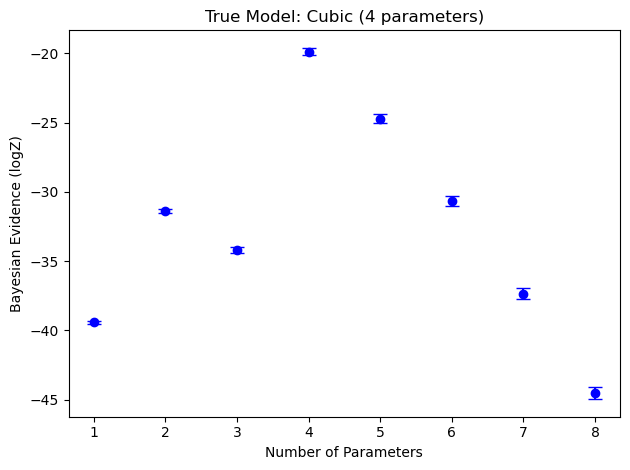

In [19]:
# Compare the evidence of different models

plt.errorbar(range(1,max_dim+1), bayesian_evidence, yerr=evidence_error,
             marker='o', ls='',label='Data', color='blue', capsize=5)

plt.xlabel('Number of Parameters')
plt.ylabel('Bayesian Evidence (logZ)')
plt.title('True Model: Cubic (4 parameters)')
plt.tight_layout()
plt.savefig('../Figures/evidence_comparisons_polynomials.png', dpi=300)
plt.show()

## Periodic Functions

I'm testing 3 models here, a simple periodic function A*sin(Bx)+C (3 parameters), a more complex periodic function which is the sum of a sin and cos function, A*sin(B*x) + C*cos(D*x) + E (5 parameters), and finally a simple linear function.

In the first example, by eye it almost appears as if there is no periodic variation and the spread of points is due to the noise. When we test the 3 models though, we see that the evidence from the periodic models is much higher than the linear model, indicating they better represent the data. The estimation of the parameters worked surprisingly well too, with the posterior distribution of the estimated parameters matching closely to the original values, even in the 2nd examples with the more complex periodic function.

In [20]:
def periodic_get_params(dim, lower, upper):
    params = np.random.uniform(lower, upper, dim)
    return params

def periodic_prior_transform(u, dim):
    return 5 * (np.array(u[:dim]))


# Asin(Bx) + C
def periodic_data_generation(params, x):
    return params[0]*np.sin(params[1]*x) + params[2]

def periodic_log_likelihood(theta, sigma):
    A, B, c = theta
    y_model = A*np.sin(B*x) + c  # change model function to the desired one
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2) - 0.5* np.log(2*np.pi*sigma**2)


# Asin(Bx)+Ccos(Dx)+E
def complex_periodic_data_generation(params, x):
    return params[0]*np.sin(params[1]*x) + params[2]*np.cos(params[3]*x) + params[4] 

def complex_periodic_log_likelihood(theta):
    A, B, C, D, E = theta
    y_model = A*np.sin(B*x) + C*np.cos(D*x) + E   # change model function to the desired one
    return -0.5 * np.sum(((y - y_model) / 0.5) ** 2) - 0.5*np.log(2*np.pi*0.5**2)

In [21]:
def run_functions():
    # Regular Periodic
    dim=3
    period_sampler = NestedSampler(lambda theta: periodic_log_likelihood(theta, sigma), 
                                   lambda u: periodic_prior_transform(u, dim),
                                   ndim=dim, nlive=1000, sample='rslice')

    period_sampler.run_nested()
    period_results = period_sampler.results


    # Complex Periodic
    dim=5
    complex_period_sampler = NestedSampler(complex_periodic_log_likelihood,
                                           lambda u: periodic_prior_transform(u, dim),
                                           ndim=dim, nlive=1000, sample='rslice')
    complex_period_sampler.run_nested()
    complex_period_results = complex_period_sampler.results

    # now try a linear function for comparison
    dim = 2
    lin_sampler =  NestedSampler(lambda theta: log_likelihood(theta, dim, sigma=0.5),
                                 lambda u: prior_transform(u, dim), ndim=dim, nlive=1000)
    lin_sampler.run_nested()
    lin_results = lin_sampler.results
    return period_results, complex_period_results, lin_results

def plot_results(period_results, complex_period_results, lin_results):
    fig, ax = dyplot.cornerplot(period_results, color='green', truths=None,
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, labels=['A','B','c'])

    fig, ax = dyplot.cornerplot(complex_period_results, color='blue', truths=None,
                               truth_color='black', show_titles=True,
                               max_n_ticks=3, labels=['A','B','C', 'D', 'E'])

    fig, ax = dyplot.cornerplot(lin_results, color='orange', truths=None,
                               truth_color='black', show_titles=True,
                               max_n_ticks=3, labels=['m', 'b'])
    return

### Simple Periodic Function

True parameters:  [0.74908024 1.90142861 1.46398788]


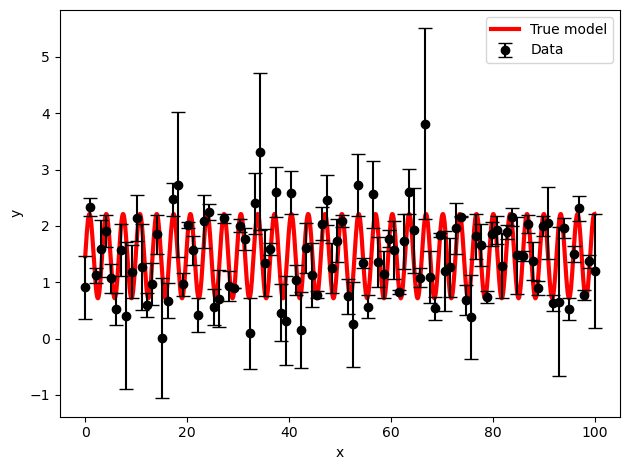

In [24]:
# Define true parameters
np.random.seed(42)
dim = 3
lower, upper = 0 , 2
true_params = periodic_get_params(dim, lower, upper)
print('True parameters: ',true_params)
# Generate x values
x = np.linspace(0, 100, 100)

# Generate y values (linear relationship with Gaussian noise)
y_true = periodic_data_generation(true_params, x)

sigma=0.5
yerr = np.random.normal(scale=sigma, size=x.shape)
y = y_true + yerr # Adding Gaussian noise

plt.errorbar(x, y, yerr=abs(yerr), marker='o', ls='',label='Data', color='k', capsize=5)
x_true_model = np.linspace(0, 100, 1000) 
y_true_model = periodic_data_generation(true_params, x_true_model)
plt.plot(x_true_model, y_true_model, label='True model', color='r', lw=3, ls='-', zorder=0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
# plt.savefig('../Figures/simple_periodic_data_generation.png', dpi=300)
plt.show()


In [25]:
period_results, complex_period_results, lin_results = run_functions()

13869it [00:45, 302.76it/s, +1000 | bound: 33 | nc: 1 | ncall: 415768 | eff(%):  3.585 | loglstar:   -inf < -52.681 <    inf | logz: -66.441 +/-  0.119 | dlogz:  0.001 >  1.009]
21254it [02:03, 172.76it/s, +1000 | bound: 66 | nc: 1 | ncall: 1039585 | eff(%):  2.143 | loglstar:   -inf < -48.640 <    inf | logz: -70.179 +/-  0.172 | dlogz:  0.001 >  1.009]
15114it [00:24, 619.62it/s, +1000 | bound: 14 | nc: 1 | ncall: 56513 | eff(%): 29.027 | loglstar:   -inf < -443.331 <    inf | logz: -458.201 +/-  0.118 | dlogz:  0.001 >  1.009] 


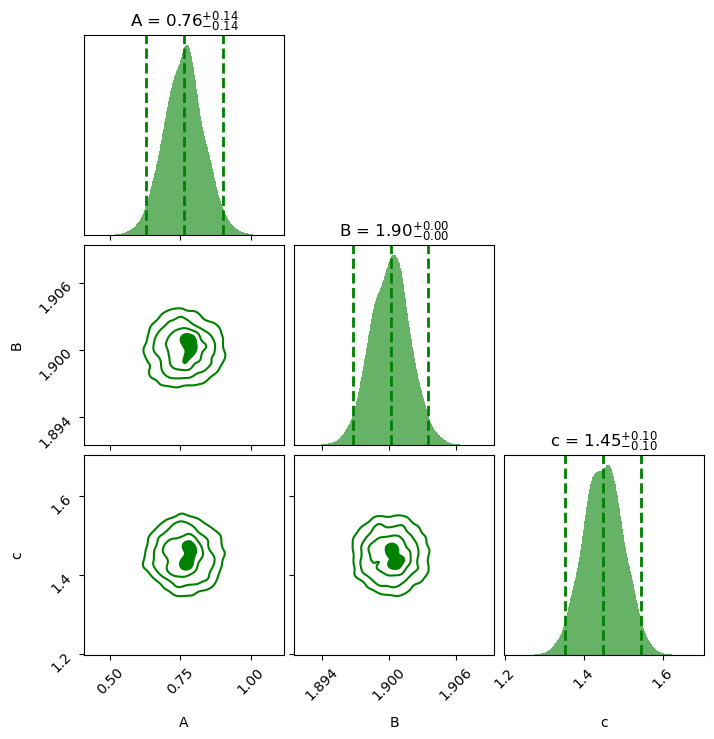

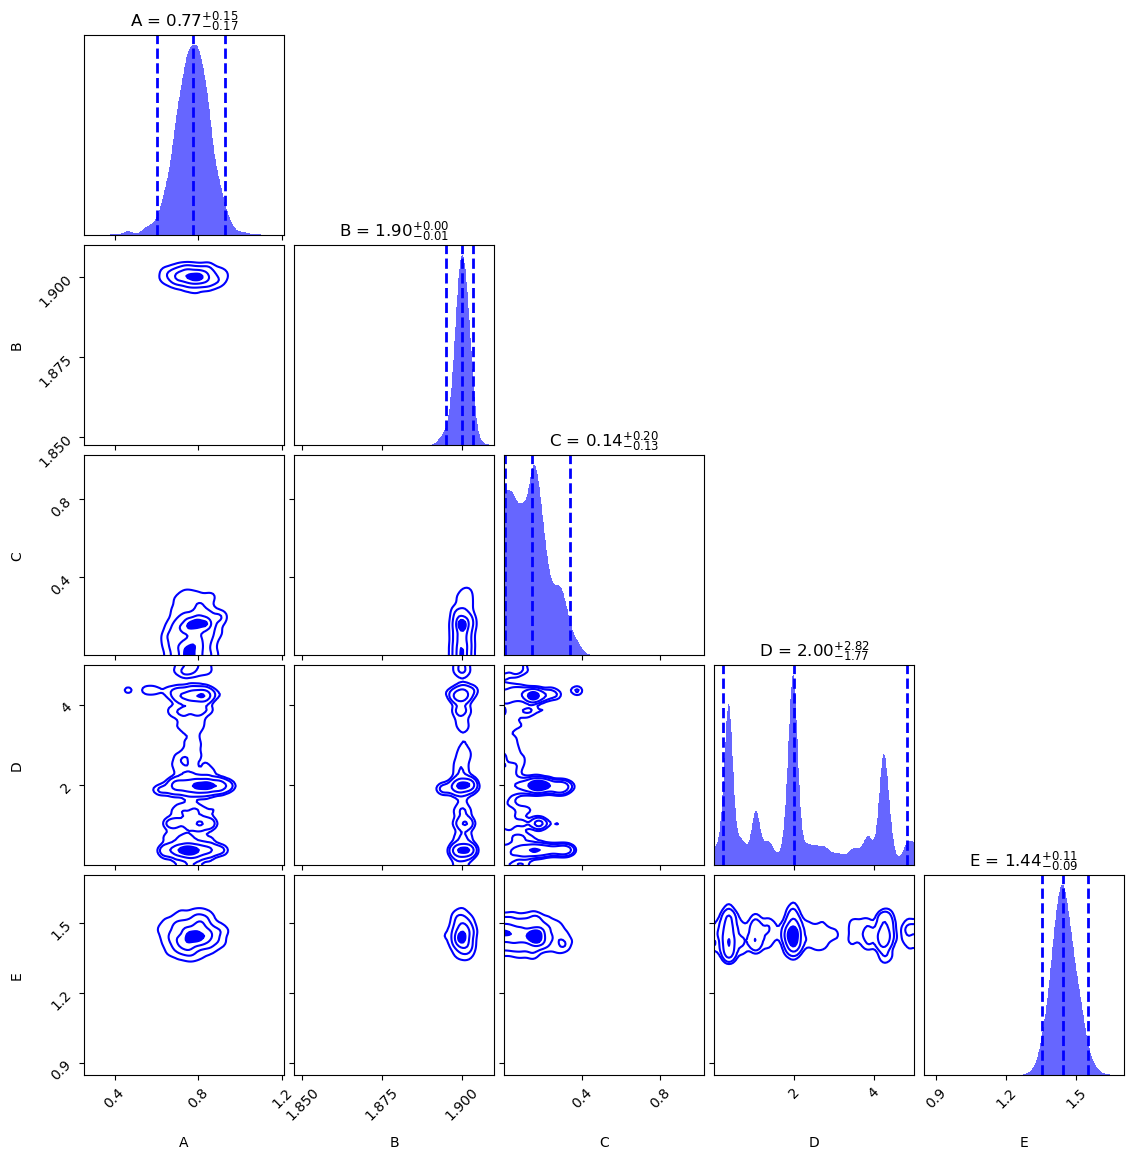

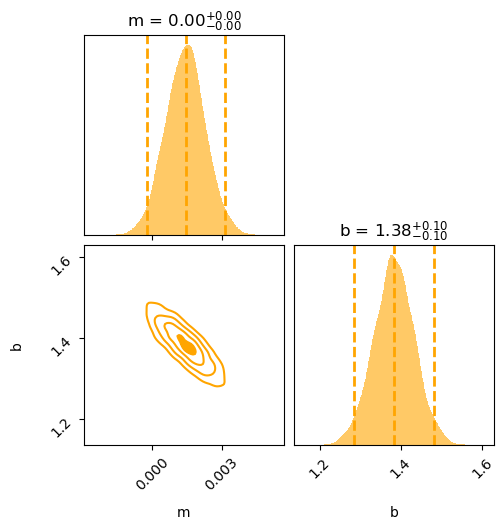

In [26]:
plot_results(period_results, complex_period_results, lin_results)

In [27]:
results = [period_results, complex_period_results, lin_results] 
model_parameters = store_parameters(results)

bayesian_evidence = []
evidence_error = []
for result in results:
    evidence = result['logz'][-1]
    error = result['logzerr'][-1]
    bayesian_evidence.append(evidence)
    evidence_error.append(error)
    


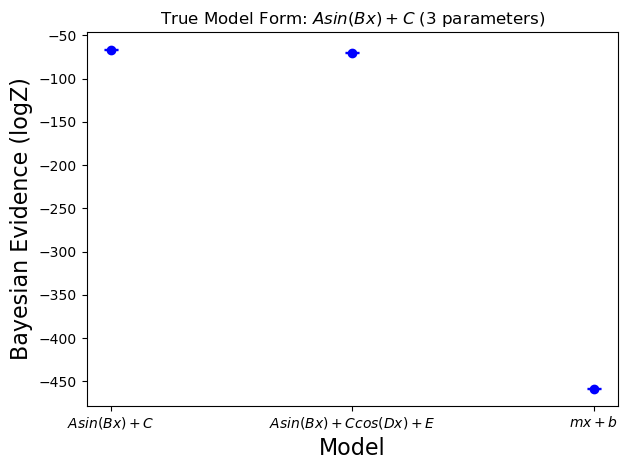

Bayes Factor simple / complex:  3.7379038223580068
Bayes Factor simple / linear:  391.76038769950344
Bayes Factor complex / linear:  388.0224838771454


In [28]:
plt.errorbar([r'$Asin(Bx)+C$', r'$Asin(Bx) + Ccos(Dx) + E$', r'$mx + b$'],
             bayesian_evidence, yerr=evidence_error,
             marker='o', ls='',label='Data', color='blue', capsize=5)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Bayesian Evidence (logZ)', fontsize=16)
plt.title(r'True Model Form: $Asin(Bx) + C$ (3 parameters)')
plt.tight_layout()
plt.show()

print('Bayes Factor simple / complex: ', bayesian_evidence[0] -  bayesian_evidence[1])
print('Bayes Factor simple / linear: ', bayesian_evidence[0] -  bayesian_evidence[2])
print('Bayes Factor complex / linear: ', bayesian_evidence[1] -  bayesian_evidence[2])




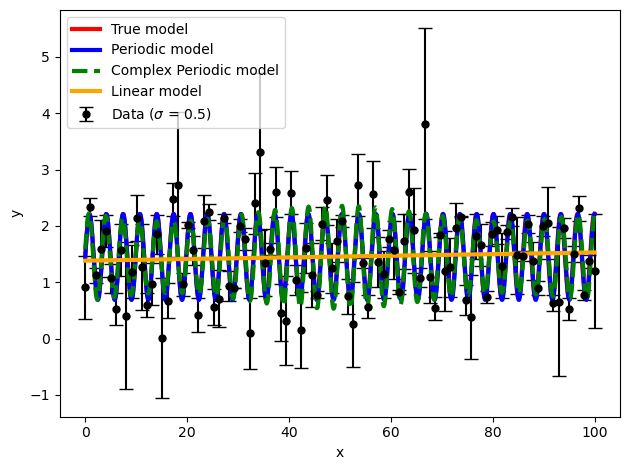

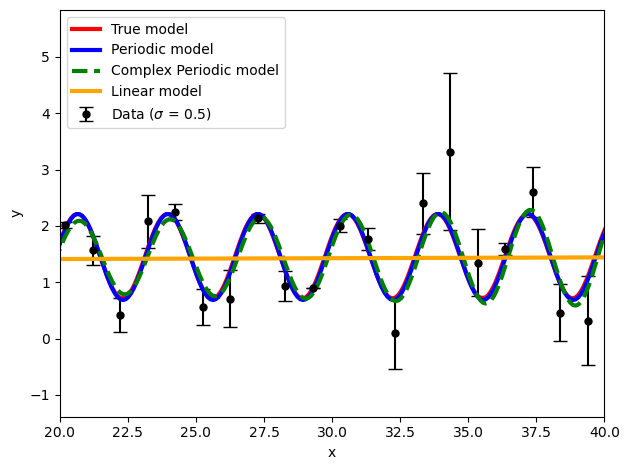

In [30]:
plt.errorbar(x, y, yerr=abs(yerr), marker='o', markersize=5, ls='',
             label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='k', capsize=5)
plt.plot(x_true_model, y_true_model, label='True model', color='red', lw=3)

#Periodic
per_y = periodic_data_generation(model_parameters[0]['median'], x_true_model)
plt.plot(x_true_model, per_y, label='Periodic model', color='b', lw=3, ls='-')

#Complex Periodic
comp_per_y = complex_periodic_data_generation(model_parameters[1]['median'], x_true_model)
plt.plot(x_true_model, comp_per_y, label='Complex Periodic model', color='g', lw=3, ls='--')

#Linear
lin_y = data_generation(model_parameters[2]['median'], x_true_model)
plt.plot(x_true_model,lin_y, label='Linear model', color='orange', lw=3, ls='-')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
# plt.savefig('../Figures/periodic_modelling.png', dpi=300)
plt.show()

### ZOOMED IN 
plt.figure()
plt.errorbar(x, y, yerr=abs(yerr), marker='o', markersize=5, ls='',
             label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='k', capsize=5)
plt.plot(x_true_model, y_true_model, label='True model', color='red', lw=3)

#Periodic
per_y = periodic_data_generation(model_parameters[0]['median'], x_true_model)
plt.plot(x_true_model, per_y, label='Periodic model', color='b', lw=3, ls='-')

#Complex Periodic
comp_per_y = complex_periodic_data_generation(model_parameters[1]['median'], x_true_model)
plt.plot(x_true_model, comp_per_y, label='Complex Periodic model', color='g', lw=3, ls='--')

#Linear
lin_y = data_generation(model_parameters[2]['median'], x_true_model)
plt.plot(x_true_model,lin_y, label='Linear model', color='orange', lw=3, ls='-')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(20,40)
plt.legend()
plt.tight_layout()
plt.show()

The simple sin function had the highest evidence and the Bayes factor with the more complex function was about 2.6. Although we see the complex function fits the true model pretty well, the extra parameters are 'penalised' for complexity, and the amplitude of the cos part of the function was estimated as close to 0 anyway, indicating it wasn't really needed.

### Complex Periodic Function

True parameters:  [0.74908024 1.90142861 1.46398788 1.19731697 0.31203728]


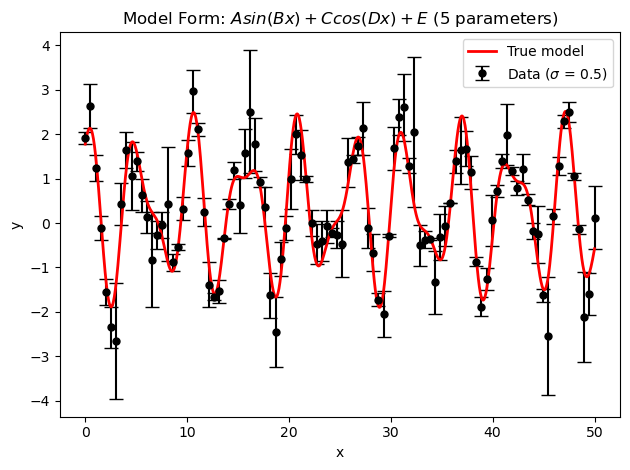

In [33]:
# Define true parameters
np.random.seed(42)
dim = 5
lower, upper = 0 , 2
true_params = get_params(dim, lower, upper)
print('True parameters: ',true_params)

# Generate data points
x = np.linspace(0, 50, 100)
y_true = complex_periodic_data_generation(true_params, x)
yerr = np.random.normal(scale=0.5, size=x.shape)
y = y_true + yerr  # Adding Gaussian noise
plt.errorbar(x, y, yerr=abs(yerr), marker='o', markersize=5, ls='',
             label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='k', capsize=5)

#true model
x_true_model = np.linspace(0,50,1000)
y_true_model = complex_periodic_data_generation(true_params, x_true_model)
plt.plot(x_true_model, y_true_model, label='True model', color='red', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Model Form: $Asin(Bx) + Ccos(Dx) + E$ (5 parameters)')
plt.legend()
plt.tight_layout()
# plt.savefig('../Figures/complex_periodic_data_generation.png',dpi=300)
plt.show()


In [34]:
period_results, complex_period_results, lin_results = run_functions()

14208it [00:40, 353.64it/s, +1000 | bound: 31 | nc: 1 | ncall: 397665 | eff(%):  3.834 | loglstar:   -inf < -230.026 <    inf | logz: -244.120 +/-  0.121 | dlogz:  0.001 >  1.009]
23954it [01:44, 228.81it/s, +1000 | bound: 61 | nc: 1 | ncall: 989431 | eff(%):  2.525 | loglstar:   -inf < -53.021 <    inf | logz: -77.056 +/-  0.165 | dlogz:  0.001 >  1.009]
14522it [00:24, 586.78it/s, +1000 | bound: 13 | nc: 1 | ncall: 55639 | eff(%): 28.408 | loglstar:   -inf < -1445.094 <    inf | logz: -1459.384 +/-  0.116 | dlogz:  0.001 >  1.009]


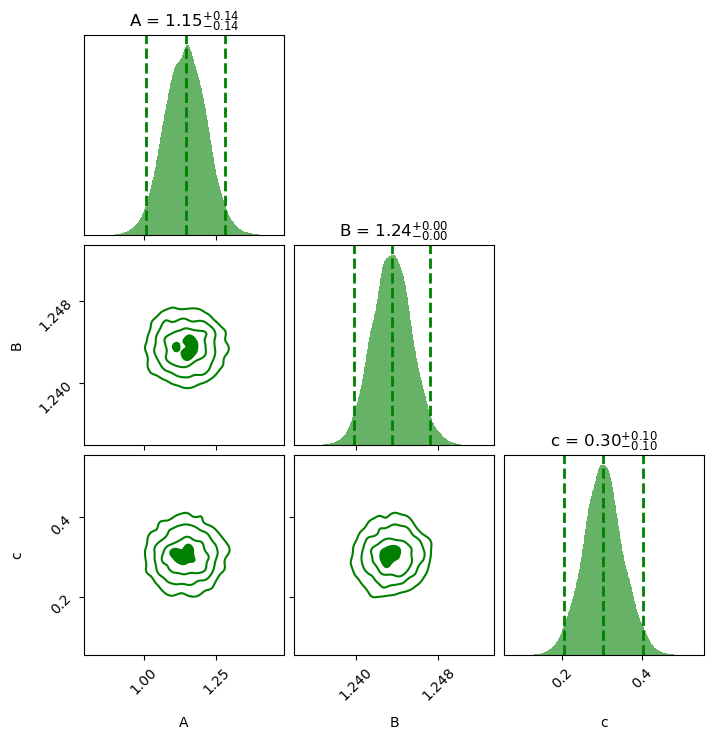

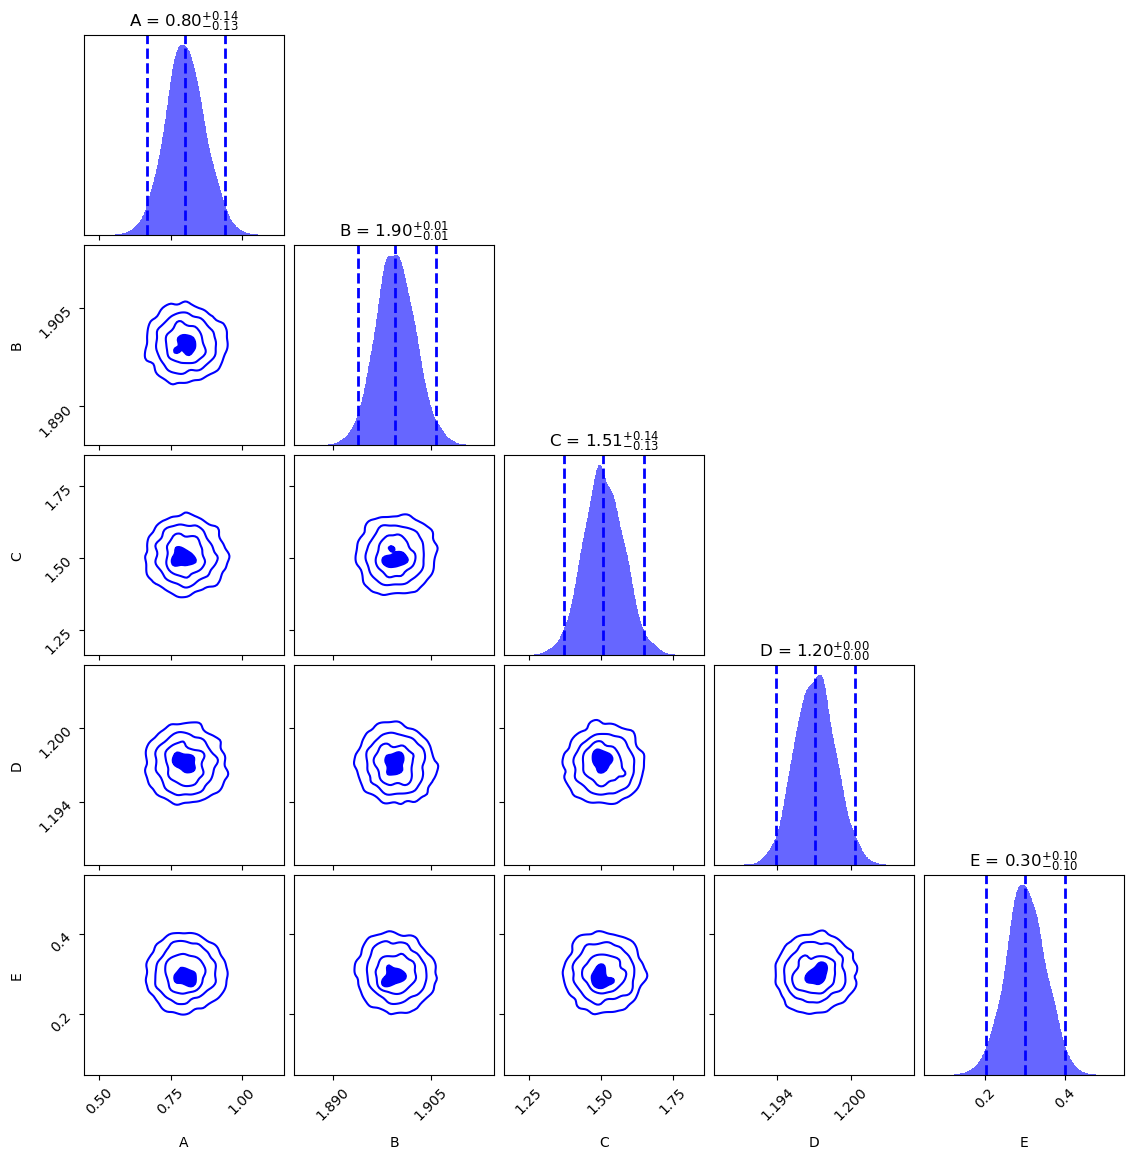

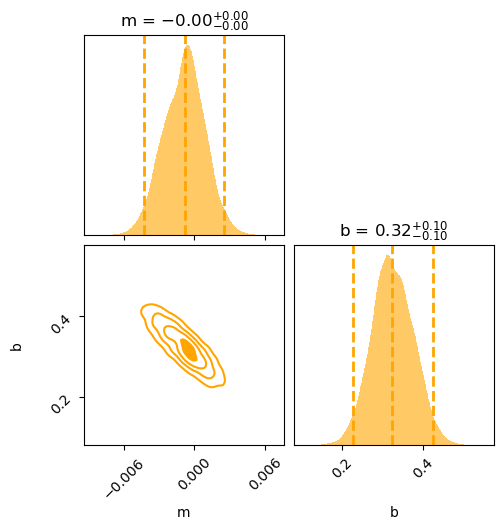

In [35]:
plot_results(period_results, complex_period_results, lin_results)

In [36]:
results = [period_results, complex_period_results, lin_results] 
model_parameters = store_parameters(results)

bayesian_evidence = []
evidence_error = []
for result in results:
    evidence = result['logz'][-1]
    error = result['logzerr'][-1]
    bayesian_evidence.append(evidence)
    evidence_error.append(error)

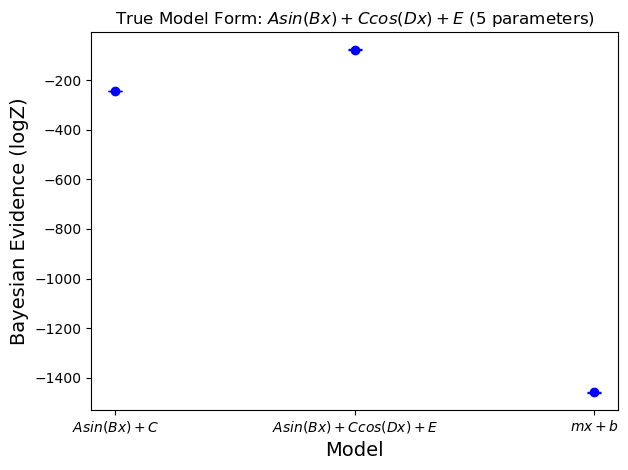

Bayes Factor simple / complex:  -167.06448647903176
Bayes Factor simple / linear:  1215.2634947444885
Bayes Factor complex / linear:  1382.3279812235203


In [37]:

plt.errorbar([r'$Asin(Bx)+C$', r'$Asin(Bx) + Ccos(Dx) + E$', r'$mx + b$'],
             bayesian_evidence, yerr=evidence_error,
             marker='o', ls='',label='Data', color='blue', capsize=5)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Bayesian Evidence (logZ)', fontsize=14)
plt.title(r'True Model Form: $Asin(Bx) + Ccos(Dx) + E$ (5 parameters)')
plt.tight_layout()
plt.show()

print('Bayes Factor simple / complex: ', bayesian_evidence[0] -  bayesian_evidence[1])
print('Bayes Factor simple / linear: ', bayesian_evidence[0] -  bayesian_evidence[2])
print('Bayes Factor complex / linear: ', bayesian_evidence[1] -  bayesian_evidence[2])




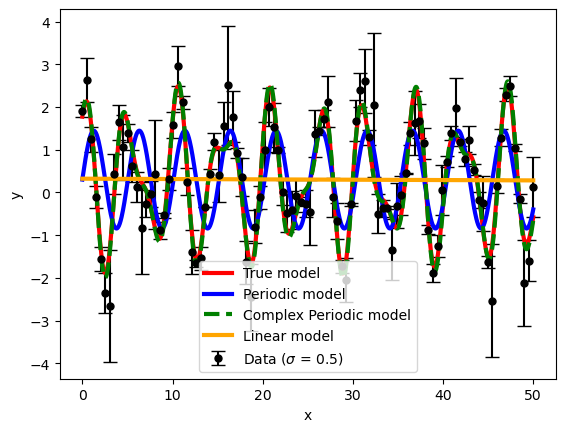

In [38]:
plt.errorbar(x, y, yerr=abs(yerr), marker='o', markersize=5, ls='',
             label='Data ($\sigma$ = {:s})'.format(str(sigma)), color='k', capsize=5)
plt.plot(x_true_model, y_true_model, label='True model', color='red', lw=3)

#Periodic
per_y = periodic_data_generation(model_parameters[0]['median'], x_true_model)
plt.plot(x_true_model, per_y, label='Periodic model', color='b', lw=3, ls='-')

#Complex Periodic
comp_per_y = complex_periodic_data_generation(model_parameters[1]['median'], x_true_model)
plt.plot(x_true_model, comp_per_y, label='Complex Periodic model', color='g', lw=3, ls='--')

#Linear
lin_y = data_generation(model_parameters[2]['median'], x_true_model)
plt.plot(x_true_model,lin_y, label='Linear model', color='orange', lw=3, ls='-')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

The evidence and Bayes factors tell us that the simple model isn't enough the describe the data correctly, and the more complex periodic function fits the data better than both the simple and linear models. 